# Hierarchical Clustering of Questionair Responses

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


In [2]:
df = pd.read_csv("CAPABLE_Questionair_Behaviourl_Models.csv")

In [3]:
df.columns

Index(['Timestamp',
       'Do you agree that your answers will be used for research purposes? ',
       'You identify yourself as:', 'Age', 'Nationality',
       'Have you been diagnosed with cancer? ',
       'I feel motivated to perform activities that I perceive having benefit to my health and well-being',
       'When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort) ',
       'My family members motivate me to look after my health',
       'When I am in a good mood I am  motivated to perform activities that benefit my health',
       'When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule',
       'Before the visit to my doctor, I tend to be more compliant with my health recommendations',
       'If I see that my peers perform health-related activities better than me,  I get discouraged ',
       'If I see that I perform health-related activities better than my

### Removing demographic information 

In [4]:
df1 = df.drop(columns=['Timestamp',
       'Do you agree that your answers will be used for research purposes? ',
     'Do you agree that your answers will be used for research purposes? .1',
       'You identify yourself as:', 'Age', 'Nationality',
       'Have you been diagnosed with cancer? ']) 

removing open question and number of responces that are not rating 1-5

In [5]:
df1 = df1.drop(columns=['What motivates you the most to maintain healthy habits?',
       'When do you feel like you can/want to perform an activity that is beneficial to your health? ',
       'How do you remind yourself to perform activities aligned with your goals? ',
                       'How many daily reminders for health-related activities would you be willing to receive? ', 'Unnamed: 37',
                       'Select a simple activity that you would be happy to perform to improve your wellbeing.  Consider this activity when answering later questions in this survey. '])

removing personality questions

In [6]:
df1 = df1.drop(columns=['I see myself as someone who is reserved',
                        'I see myself as someone who is generally trusting',
       'I see myself as someone who tends to be lazy',
       'I see myself as someone who is relaxed, handles stress well',
       'I see myself as someone who has few artistic interests',
       'I see myself as someone who is outgoing, sociable',
       'I see myself as someone who tends to find fault with others',
       'I see myself as someone who does a thorough job',
       'I see myself as someone who gets nervous easily',
       'I see myself as someone who has an active imagination'
     ])

In [7]:
df1 = df1.fillna(3) # neutral

In [8]:
def get_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dic = dendrogram(linkage_matrix, **kwargs)
    return dic

In [9]:
model = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

model = model.fit(df1)


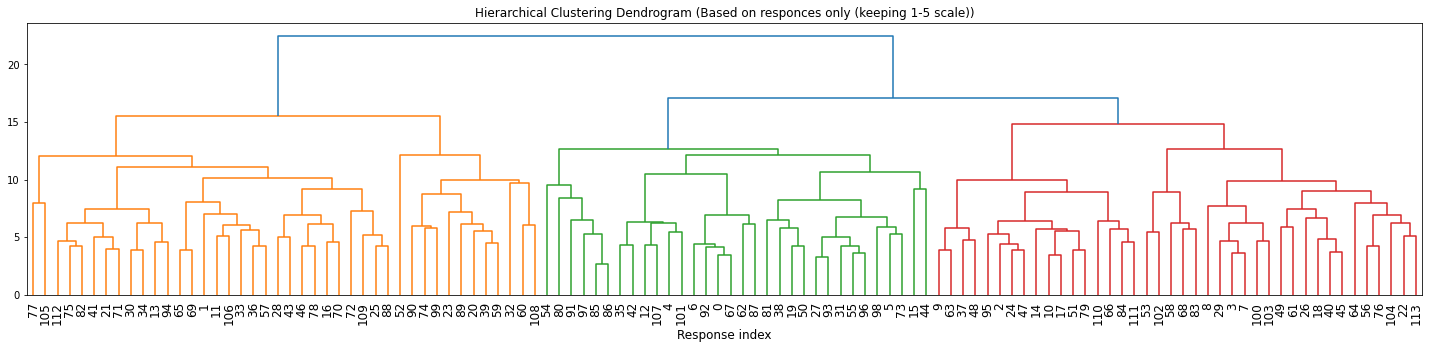

In [10]:
fig = plt.figure(figsize = (25,5))
plt.title('Hierarchical Clustering Dendrogram (Based on responces only (keeping 1-5 scale))')
# plot the top three levels of the dendrogram
get_dendrogram(model, truncate_mode='level', p=12)
plt.xlabel("Response index", fontsize= 12 )
plt.xticks(fontsize= 12 )
plt.show()

#### Colaps rating into positive (4,5),  neutral(3) and negative negative(1,2)

In [11]:
def squeezRating(rating):
    
    if rating <3:
        return 'negative'
    elif rating >3:
        return 'positive'
    else:
        return 'neutral'
        

In [12]:
dfs = df1.applymap(lambda x: squeezRating(x))

In [13]:
def rating2cat(rating):
    
    if rating == 'negative':
        return 0
    elif rating == 'positive':
        return 2
    else:
        return 1

In [14]:
dfs = dfs.applymap(lambda x: rating2cat(x))

In [15]:
dfs.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,I am more likely to perform suggested health-related activity when I am not focused on any other tasks,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.
0,2,2,2,2,1,0,1,1,1,2,...,2,0,2,0,2,1,2,2,0,2
1,1,2,0,2,0,0,0,1,1,2,...,2,2,1,2,0,2,2,0,0,2
2,1,2,1,2,2,1,1,2,2,2,...,2,2,2,2,0,2,1,2,2,2
3,2,2,2,2,0,1,0,2,1,2,...,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,1,2,2,2,...,2,2,2,1,2,0,2,2,0,2


In [16]:
model3 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

model3 = model3.fit(dfs)

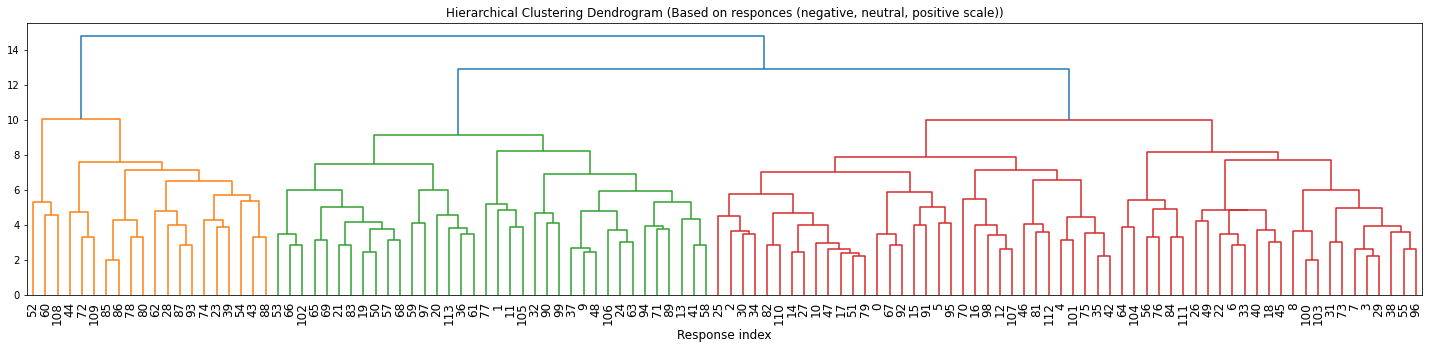

In [17]:
fig = plt.figure(figsize = (25,5))
plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale))')
# plot the top three levels of the dendrogram
get_dendrogram(model3, truncate_mode='level', p=12)
plt.xlabel("Response index", fontsize= 12 )
plt.xticks(fontsize= 12 )
plt.show()

### Check Cluster stability
All responses 1-5
Random dropm of 10% of responces

11
Dropped the following responces:  [ 36  47  16   8  78  68 112  45 108   5  30]


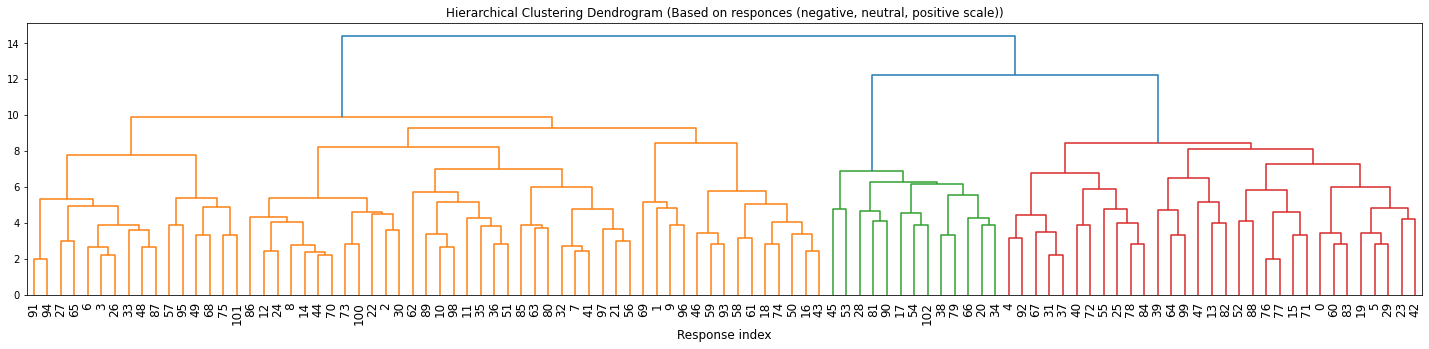

Dropped the following responces:  [ 91 103  87  65   6  13  76  62  84  88  25]


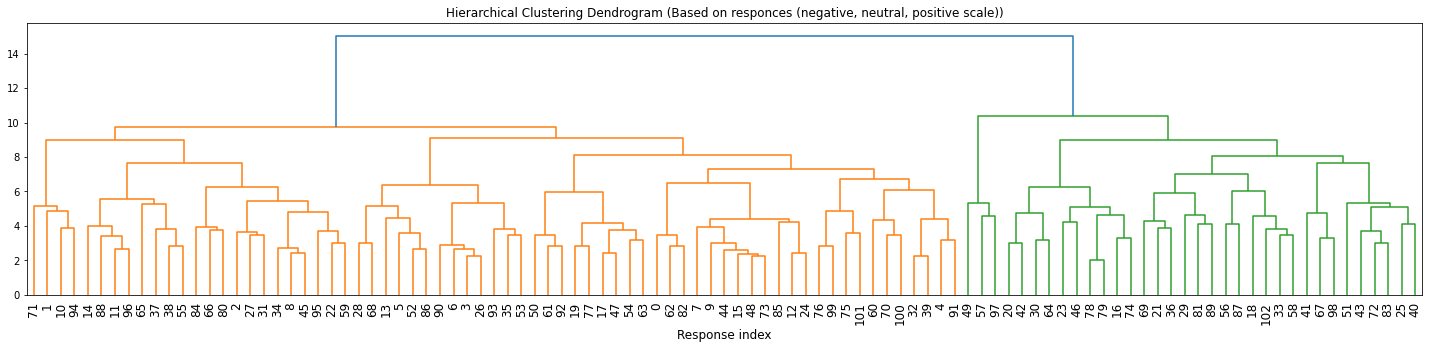

Dropped the following responces:  [ 58  11  25  47  66   6  34  13  14  30 104]


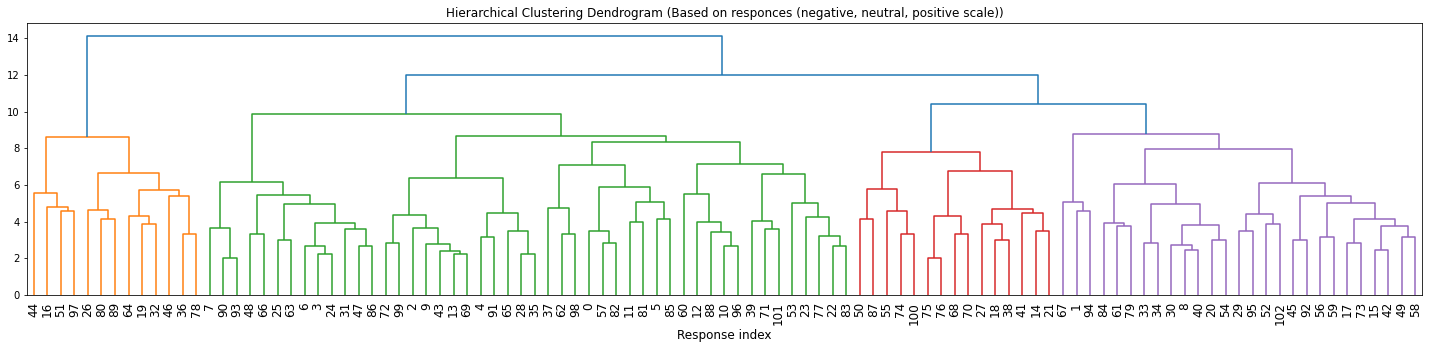

Dropped the following responces:  [ 67  84  46  34 108  64  98  85   1  19  54]


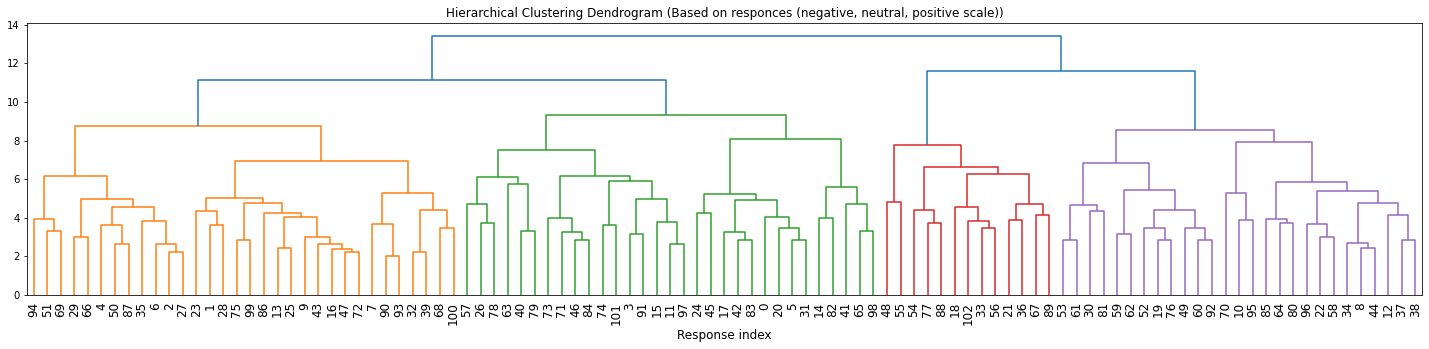

Dropped the following responces:  [ 55  71  87  99  67 112 103  84  60 101   3]


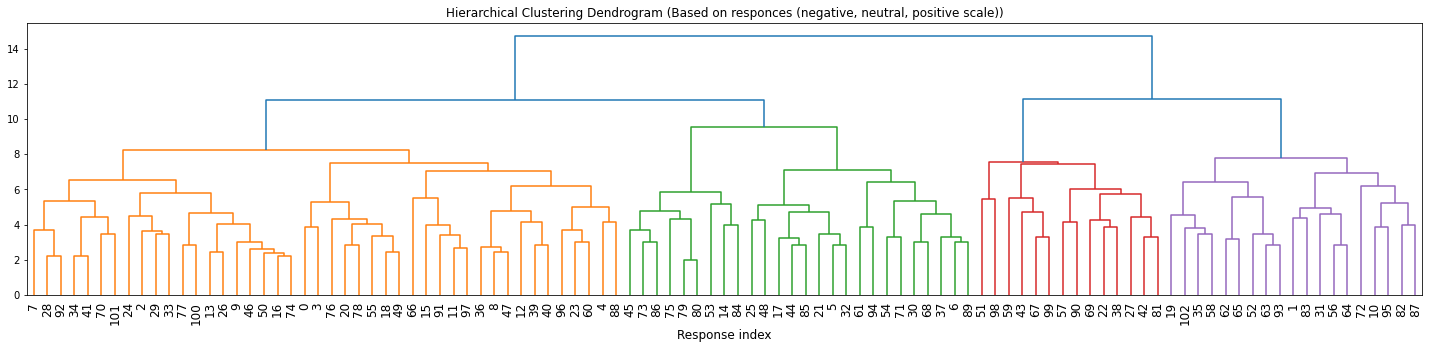

In [18]:
remove_n = int((len(dfs) * 10)/ 100)
print(remove_n)
for i in range(5):
    drop_indices = np.random.choice(dfs.index, remove_n, replace=False)
    print("Dropped the following responces: ", drop_indices)
    df_subset = dfs.drop(drop_indices)
    model4 = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
    model4 = model4.fit(df_subset)
    fig = plt.figure(figsize = (25,5))
    plt.title('Hierarchical Clustering Dendrogram (Based on responces (negative, neutral, positive scale))')
    # plot the top three levels of the dendrogram
    get_dendrogram(model4, truncate_mode='level', p=12)
    plt.xlabel("Response index", fontsize= 12 )
    plt.xticks(fontsize= 12 )
    plt.show()

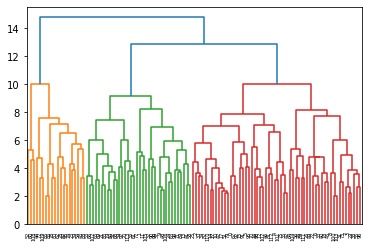

In [33]:
d = get_dendrogram(model3, truncate_mode='level', p=12)

In [34]:
# d['leaves'], d['leaves_color_list']

In [35]:
clust = pd.DataFrame(index =d['leaves'],data=d['leaves_color_list'], columns=['cluster'])

In [36]:
mCluster = pd.merge(dfs,clust, how='inner', left_index=True, right_index=True)

In [37]:
mCluster.head()

,I feel motivated to perform activities that I perceive having benefit to my health and well-being,When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort),My family members motivate me to look after my health,When I am in a good mood I am motivated to perform activities that benefit my health,When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule,"Before the visit to my doctor, I tend to be more compliant with my health recommendations","If I see that my peers perform health-related activities better than me, I get discouraged",If I see that I perform health-related activities better than my peers I feel motivated,I am keen to perform a simple activity for a longer time when I compete with others,I am keen to perform a simple activity for a longer time when I want to break my own record,...,When I am stressed I am unlikely to respond to any reminders for health-related activities,When I am stressed I find it helpful to perform a relaxing/calming down activity,When I am tired I am unlikely to respond to reminders for health-related activities,I am likely to respond to reminders for health-related activities when I am bored,I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed,I am likely to respond to reminders for health-related activities when I am relaxed,"I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)",I would respond to reminders for health-related activities while I am walking.,I would respond to reminders for health-related activities while I am sitting or standing.,cluster
0,2,2,2,2,1,0,1,1,1,2,...,0,2,0,2,1,2,2,0,2,C3
1,1,2,0,2,0,0,0,1,1,2,...,2,1,2,0,2,2,0,0,2,C2
2,1,2,1,2,2,1,1,2,2,2,...,2,2,2,0,2,1,2,2,2,C3
3,2,2,2,2,0,1,0,2,1,2,...,2,2,2,2,2,2,2,2,2,C3
4,2,2,2,2,2,2,1,2,2,2,...,2,2,1,2,0,2,2,0,2,C3


I feel motivated to perform activities that I perceive having benefit to my health and well-being


C:\Users\Aneta\anaconda3\envs\rl\lib\site-packages\pandas\plotting\_matplotlib\hist.py:354: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


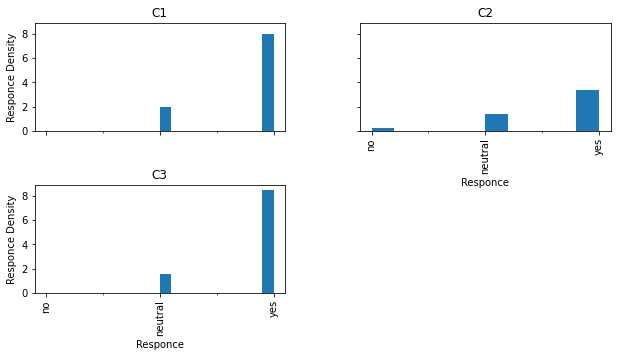

When I had a good night sleep I feel more motivated to perform activities that benefit my health (make an extra effort) 


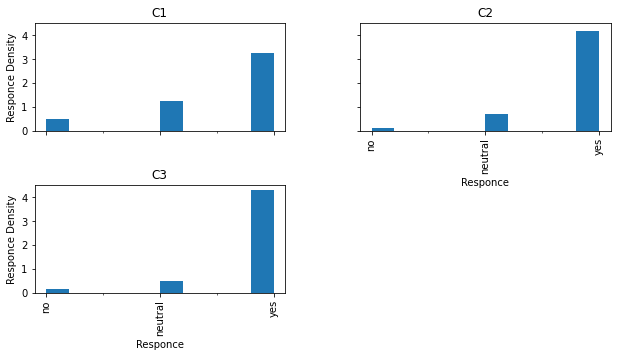

My family members motivate me to look after my health


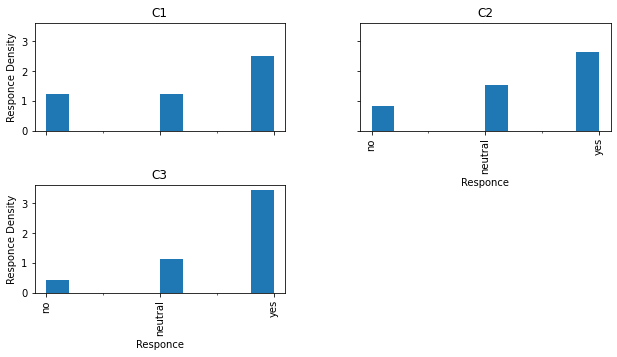

When I am in a good mood I am  motivated to perform activities that benefit my health


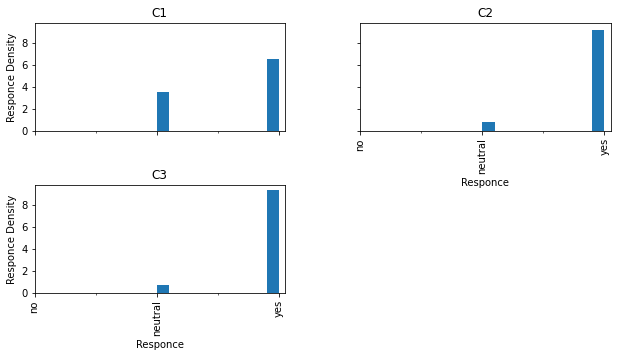

When I feel low I cannot be convinced to perform any activities that are not a part of my normal daily schedule


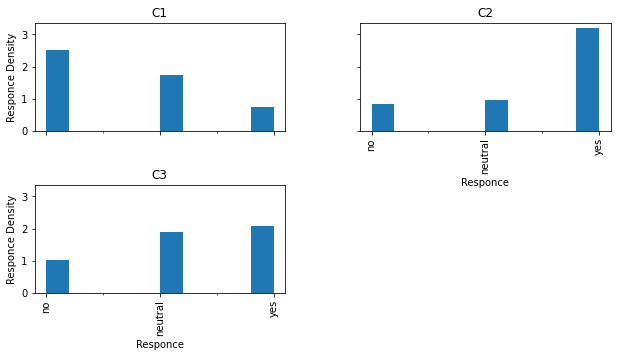

Before the visit to my doctor, I tend to be more compliant with my health recommendations


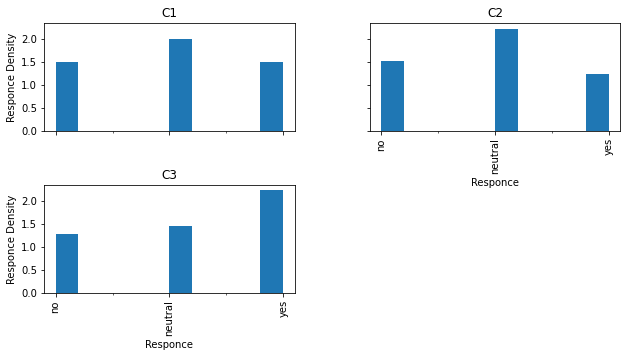

If I see that my peers perform health-related activities better than me,  I get discouraged 


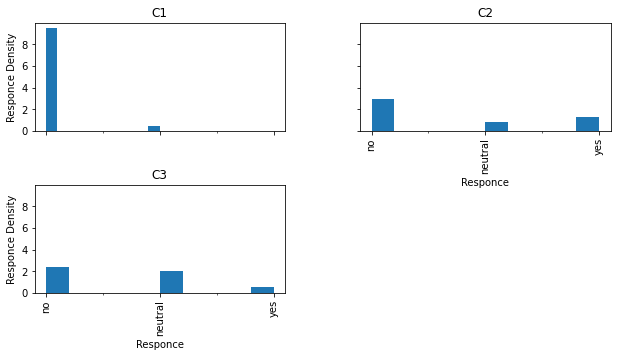

If I see that I perform health-related activities better than my peers I feel motivated


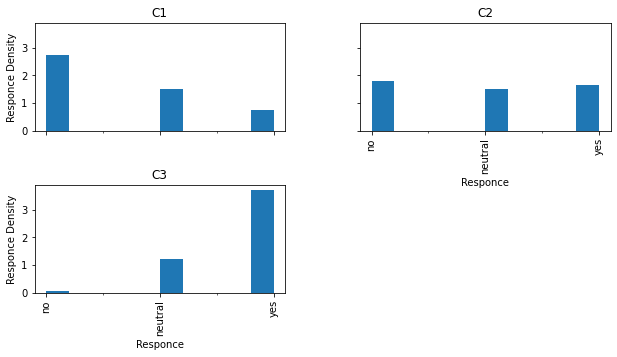

I am keen to perform a simple activity for a longer time when I compete with others


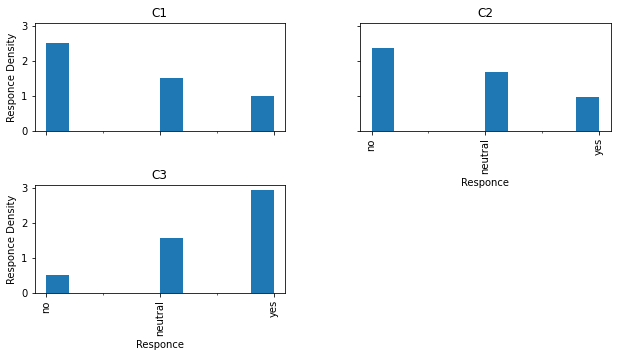

I am keen to perform a simple activity for a longer time when I want to break my own record


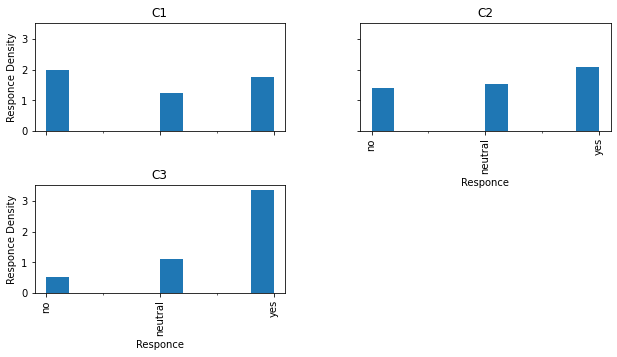

I feel stressed when I do not complete my daily health-related activities


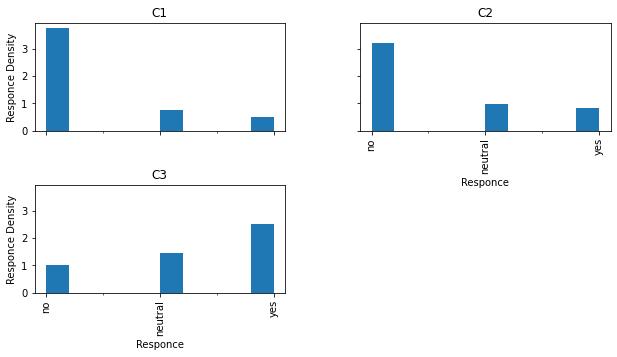

If I do not like recommended health-related activity, I would not perform it


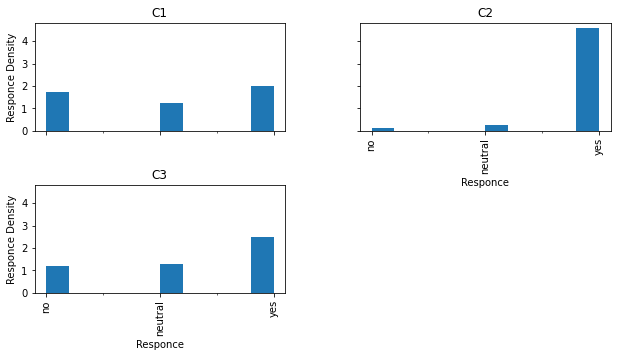

I am likely to perform a harder health-related activity when I am well rested


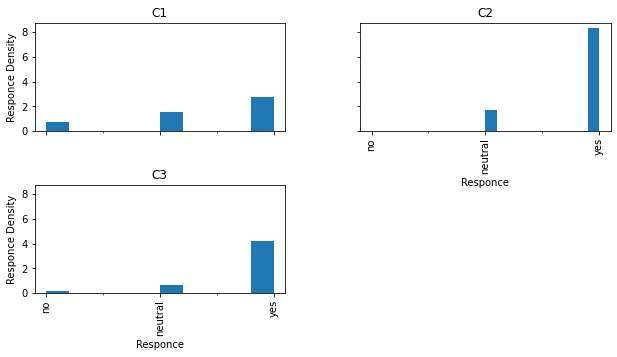

I am confident to perform a suggested health-related activity if I performed it already multiple times before


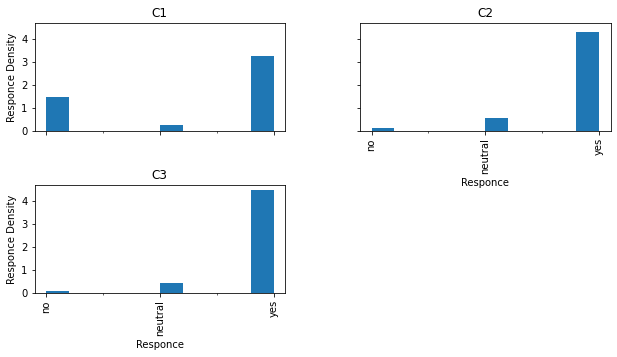

I would not perform a simple health-related activity (such as deep breathing) for longer than the recommended minimum, as I would get bored


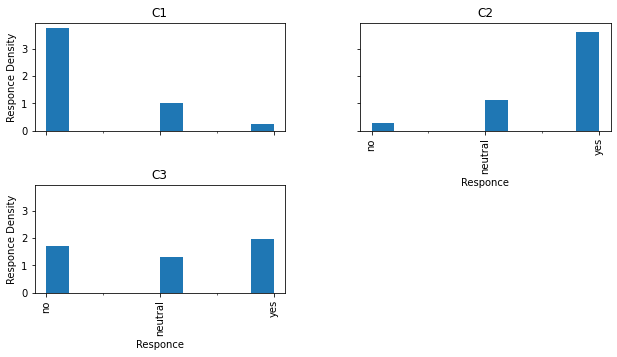

I am keen to perform a simple health-related activity for longer than the recommended minimum time, when I enjoy it 


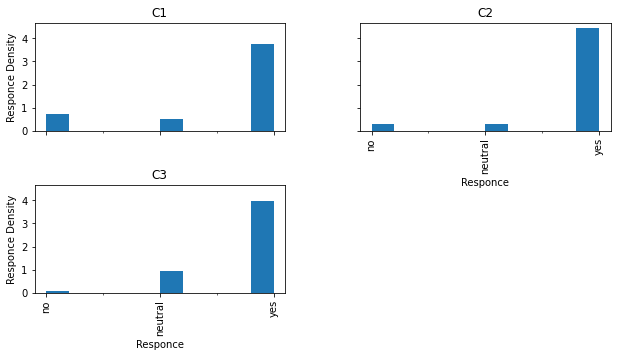

I am more likely to perform suggested health-related activity  when I am not focused on any other tasks


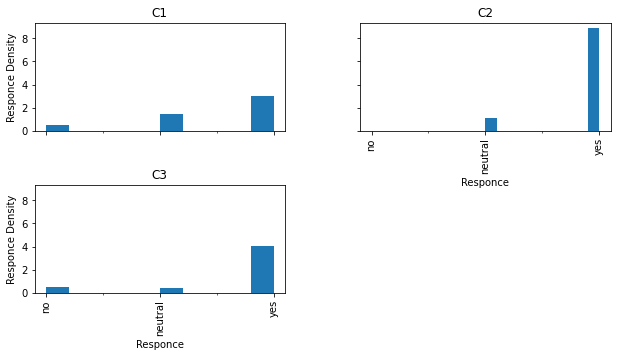

When I am stressed I am unlikely to respond to any reminders for health-related activities


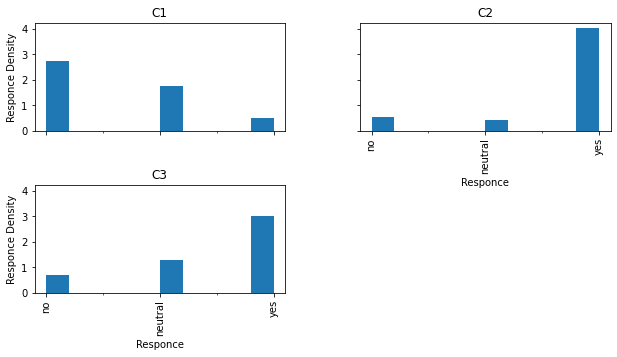

When I am stressed I find it helpful to perform a relaxing/calming down activity


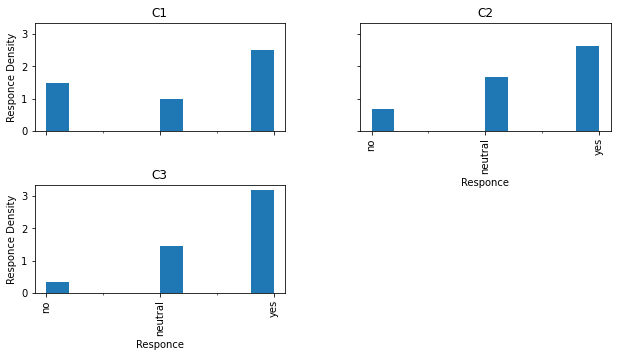

When I am tired  I am unlikely to respond to reminders for health-related activities


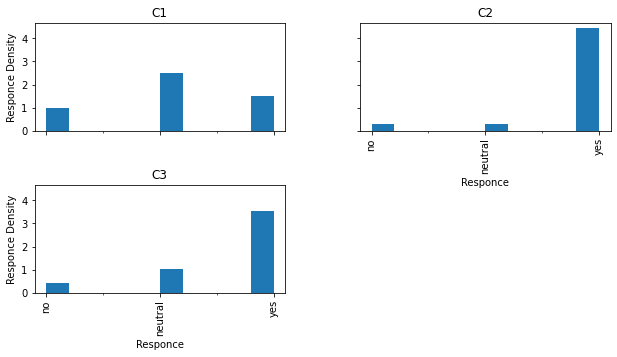

I am likely to respond to reminders for health-related activities when I am bored


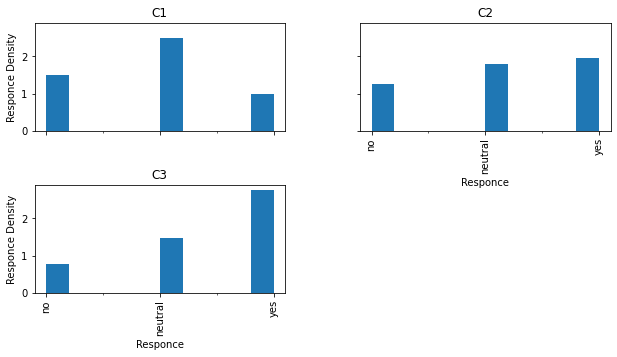

I am more likely to respond to reminders for health-related activities when I am relaxed than when I am stressed


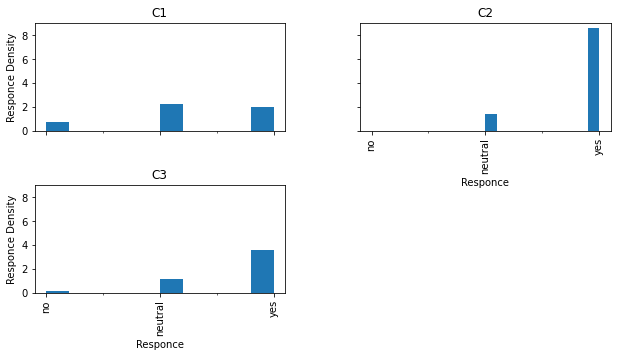

I am likely to respond to reminders for health-related activities when I am relaxed


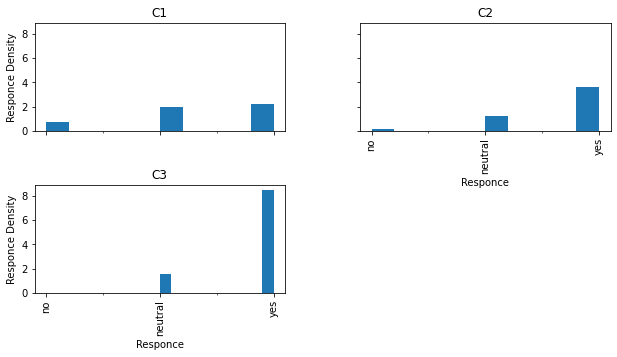

I am more likely to respond to the reminders for health-related activities when I am at home than elsewhere (park, shop, etc.)


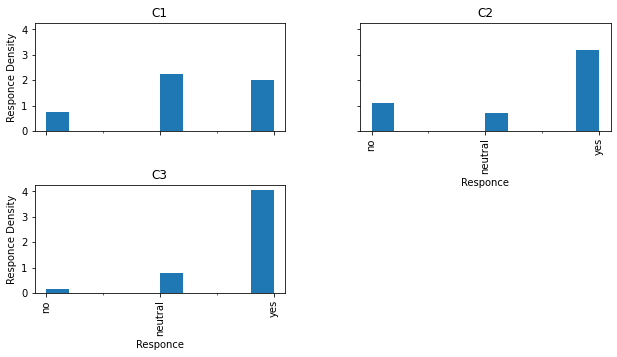

I would respond to reminders for health-related activities while I am walking. 


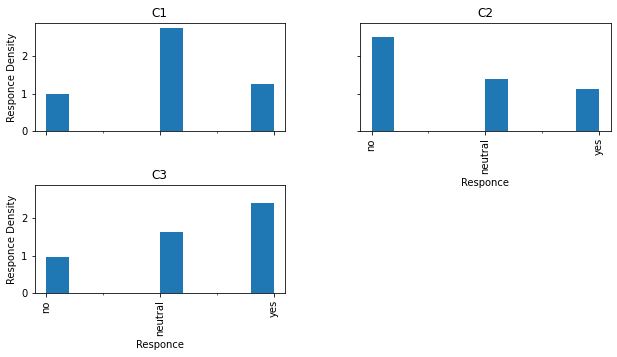

I would respond to reminders for health-related activities while I am sitting or standing. 


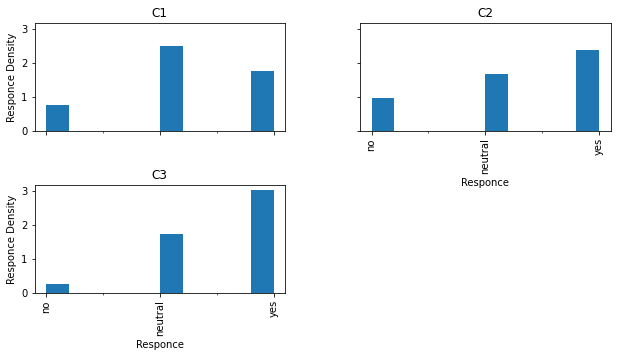

In [38]:
for q in dfs.columns:
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
#     ticks = [1,2,3,4,5]
    ticks = [0,1,2]
    print(q)
    axarr =    mCluster[q].hist(by=mCluster['cluster'], ax = ax, 
                                sharex=True, sharey=True, align='mid', density=True)

    for ax in axarr.flatten():
        ax.set_xlabel("Responce")
        ax.set_xticks(ticks, minor=False)
        ax.set_xticklabels(  ['no', 'neutral', 'yes'])
#         ax.set_xticklabels( ['negative','', 'neutral', '','positive'])
        ax.set_ylabel("Responce Density")
    
    plt.show()